<a href="https://colab.research.google.com/github/abhyanth-learner/MagicWand-TFLite-ESP32-MPU6050/blob/1-05-2022/train/attack-test-original_tflite_quantized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORT STATEMENTS**

In [173]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(5)
import random
import pandas as pd
import pickle

**ORIGINAL MODEL** 
1. .h5 file calling
2. attack vector generation and implemtation on        original .h5 file
3. plotting  of the results
4. saving the attack vectors in pickle format






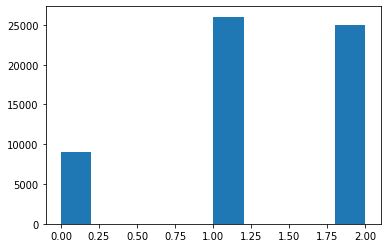

((60000, 128, 3, 1), (60000,))

In [187]:
# load the model
model=tf.keras.models.load_model("original.h5")
# Generating the attack vectors
av1=np.random.randn(50000,128,3,1)
av2=np.random.rand(10000,128,3,1)
av=np.concatenate((av1,av2))
#prediction using the attack vectors
av_out=model.predict(av)
# print(av_out)
# av.shape,av_out.shape
av_class=np.argmax(av_out,axis=1)
# av_class
# np.unique(av_class)
plt.hist(av_class)
plt.show()
file = open('attack_vectors.pkl', 'wb')
pickle.dump([av,av_class],file)
file.close()
pickle_off = open("attack_vectors.pkl", 'rb')
contents_pickle = pickle.load(pickle_off)
contents_pickle[0].shape,contents_pickle[1].shape

**ORIGINAL TFLITE AND QUANTIZED MODEL** 
1. .tflite file calling
2. attack implemtation on original tflite(including quantized) file
3. plotting  of the results







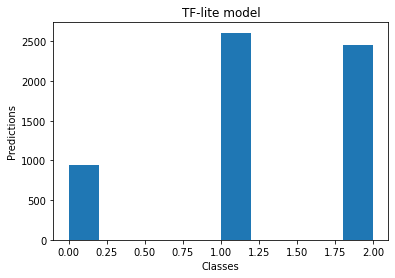

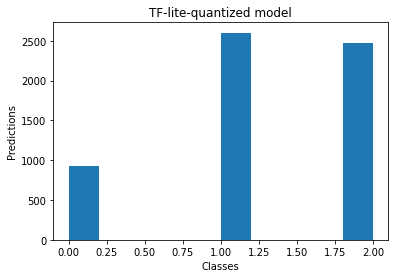

In [188]:
# Instantiate an interpreter for each model
gesture_model = tf.lite.Interpreter('model.tflite')
gesture_model_quantized = tf.lite.Interpreter('model_quantized.tflite')

# Allocate memory for each model
gesture_model.allocate_tensors()
gesture_model_quantized.allocate_tensors()

# Get indexes of the input and output tensors
gesture_model_input_index = gesture_model.get_input_details()[0]["index"]
gesture_model_output_index = gesture_model.get_output_details()[0]["index"]
gesture_model_quantized_input_index = gesture_model_quantized.get_input_details()[0]["index"]
gesture_model_quantized_output_index = \
gesture_model_quantized.get_output_details()[0]["index"]
# gesture_model_input_index,gesture_model_output_index
# Create arrays to store the results
gesture_model_predictions = []
gesture_model_quantized_predictions = []
av1=np.random.randn(5000,128,3,1)
av2=np.random.rand(1000,128,3,1)
x_test=np.concatenate((av1,av2))
# Run each model's interpreter for each value and store the results in arrays
for x_value in x_test:
#     print(len(x_value))
    # Create a 2D tensor wrapping the current x value
    x_value_tensor = tf.convert_to_tensor([x_value], dtype=np.float32)
#     print("answer2:::::::;;",x_value_tensor)
    # Write the value to the input tensor
    gesture_model.set_tensor(gesture_model_input_index, x_value_tensor)
    # Run inference
    gesture_model.invoke()
   # Read the prediction from the output tensor
    gesture_model_predictions.append(
    gesture_model.get_tensor(gesture_model_output_index)[0])
   # Do the same for the quantized model
    gesture_model_quantized.set_tensor(gesture_model_quantized_input_index, x_value_tensor)
    gesture_model_quantized.invoke()
    gesture_model_quantized_predictions.append(
    gesture_model_quantized.get_tensor(gesture_model_quantized_output_index)[0])
# print(gesture_model_predictions)
fig, ax = plt.subplots(1, 1)
avlite_class=np.argmax(gesture_model_predictions,axis=1)
ax.hist(avlite_class)
# Set title
ax.set_title("TF-lite model")
ax.set_xlabel('Classes')
ax.set_ylabel('Predictions')
plt.show()
avlitequantized_class=np.argmax(gesture_model_quantized_predictions,axis=1)
fig, ax = plt.subplots(1, 1)
plt.hist(avlitequantized_class)
ax.set_title("TF-lite-quantized model")
ax.set_xlabel('Classes')
ax.set_ylabel('Predictions')
plt.show()

**STOLEN MODEL ARCHITECTURE AND TRAINING**




In [198]:
Stolen_model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          8, (4, 3),
          padding="same",
          activation="relu",
          input_shape=(128, 3, 1)),  # output_shape=(batch, 128, 3, 8)
      tf.keras.layers.MaxPool2D((3, 3)),  # (batch, 42, 1, 8)
      tf.keras.layers.Dropout(0.1),  # (batch, 42, 1, 8)
      tf.keras.layers.Conv2D(32, (4, 1), padding="same",
                             activation="relu"),  # (batch, 42, 1, 16)
      tf.keras.layers.Conv2D(64, (4, 1), padding="same",
                             activation="relu"),  # (batch, 42, 1, 16)
      tf.keras.layers.MaxPool2D((3, 1), padding="same"),  # (batch, 14, 1, 16)
      tf.keras.layers.Dropout(0.5),  # (batch, 14, 1, 16)
      tf.keras.layers.Flatten(),  # (batch, 224)
      tf.keras.layers.Dense(32, activation="relu"),  # (batch, 16)
      tf.keras.layers.Dropout(0.5),  # (batch, 16)
      tf.keras.layers.Dense(3, activation="softmax")  # (batch, 4)
  ])

In [199]:
# model.compile(loss='categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
Stolen_model.compile(optimizer="adam",
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])
# model.compile(optimizer="RMSprop",
#                 loss="sparse_categorical_crossentropy",
#                 metrics=["accuracy"])

In [200]:
Stolen_model.fit(contents_pickle[0],contents_pickle[1],epochs=20,steps_per_epoch=200)


Epoch 1/20
200/200 [==============================] - 17s 80ms/step - loss: 0.9635 - accuracy: 0.5220
Epoch 2/20
200/200 [==============================] - 16s 79ms/step - loss: 0.9003 - accuracy: 0.5839
Epoch 3/20
200/200 [==============================] - 16s 80ms/step - loss: 0.8736 - accuracy: 0.6026
Epoch 4/20
200/200 [==============================] - 16s 81ms/step - loss: 0.8534 - accuracy: 0.6149
Epoch 5/20
200/200 [==============================] - 16s 79ms/step - loss: 0.8352 - accuracy: 0.6261
Epoch 6/20
200/200 [==============================] - 16s 79ms/step - loss: 0.8190 - accuracy: 0.6332
Epoch 7/20
200/200 [==============================] - 16s 79ms/step - loss: 0.8049 - accuracy: 0.6405
Epoch 8/20
200/200 [==============================] - 16s 78ms/step - loss: 0.7904 - accuracy: 0.6486
Epoch 9/20
200/200 [==============================] - 16s 80ms/step - loss: 0.7801 - accuracy: 0.6519
Epoch 10/20
200/200 [==============================] - 16s 80ms/step - loss: 0.777

**TESTING THE STOLEN MODEL USING ORIGINAL TEST DATA**


1. calling data loader function to load the test data, 
Getting the accuracy and loss of the stolen model
2. Storing the .h5 file of the stolen model
3. Plotting the results
4. Converting the stolen model to tflite and storing the .tflite file



In [201]:
from data_load import DataLoader
import argparse
def reshape_function(data, label):
  reshaped_data = tf.reshape(data, [-1, 3, 1])
  return reshaped_data, label
def load_data(train_data_path, valid_data_path, test_data_path, seq_length):
  data_loader = DataLoader(train_data_path,
                           valid_data_path,
                           test_data_path,
                           seq_length=seq_length)
  data_loader.format()
  return data_loader.train_len, data_loader.train_data, data_loader.valid_len, \
      data_loader.valid_data, data_loader.test_len, data_loader.test_data
seq_length = 128
train_len, train_data, valid_len, valid_data, test_len, test_data = \
load_data("./train", "./valid",
                  "./test", seq_length)
def reshape_function(data, label):
  reshaped_data = tf.reshape(data, [-1, 3, 1])
  return reshaped_data, label
test_data = test_data.map(reshape_function)
test_data_batch = test_data.batch(64)
loss, acc = Stolen_model.evaluate(test_data_batch)


train_data_length:4200
valid_data_length:55
test_data_length:59
2/2 [==============================] - 0s 17ms/step - loss: 1.8419 - accuracy: 0.6780


In [202]:
tf.keras.models.save_model(
    Stolen_model, 'stolen_model.h5', overwrite=True, include_optimizer=True, save_format='h5',
    signatures=None, options=None)

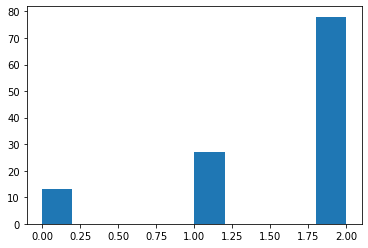

In [203]:
Stolen_model=tf.keras.models.load_model("stolen_model.h5")
av_out=Stolen_model.predict(test_data_batch)
# print(av_out)
# av.shape,av_out.shape
av_class=np.argmax(av_out,axis=1)
# av_class
# np.unique(av_class)
plt.hist(av_class)
plt.show()


In [145]:
converter=tf.lite.TFLiteConverter.from_keras_model(Stolen_model)
tflite_modelstolen=converter.convert()

open("stolen_model.tflite","wb").write(tflite_modelstolen)

INFO:tensorflow:Assets written to: /tmp/tmpy8v__7l8/assets


INFO:tensorflow:Assets written to: /tmp/tmpy8v__7l8/assets


65604

**DEFENCE**


1.   Converting the attack vector dataset to tesnor slice dataset to make similar to the original training dataset
2.   Preparing the training dataset for the defense model by combining the attack vectors and original training dataset
3. Storing the newely generated dataset in pickle format 



In [146]:
av_training_dataset=tf.data.Dataset.from_tensor_slices((ans[0],ans[1]))

In [57]:
train_data = train_data.map(reshape_function)
orig_data=next(train_data.batch(9000).as_numpy_iterator())[0]
orig_labels=next(train_data.batch(9000).as_numpy_iterator())[1]
av_data=next(av_training_dataset.batch(9000).as_numpy_iterator())[0]
av_labels=next(av_training_dataset.batch(9000).as_numpy_iterator())[1]
orig_data.shape,orig_labels.shape,av_data.shape,av_labels.shape
new_av_lables = np.where( av_labels< 3, 3, av_labels)
final_data=np.concatenate([orig_data,av_data])
final_labels=np.concatenate([orig_labels,new_av_lables])
final_data.shape,final_labels.shape

In [58]:
file_new = open('new_training_data.pkl', 'wb')
pickle.dump([final_data,final_labels],file_new)
file_new.close()
pickle_off_new = open("new_training_data.pkl", 'rb')
contents_pickle_new = pickle.load(pickle_off_new)
contents_pickle_new[0].shape,contents_pickle_new[1].shape

((8400, 128, 3, 1), (8400,), (9000, 128, 3, 1), (9000,))

array([3, 3, 3, ..., 3, 3, 3])

((17400, 128, 3, 1), (17400,))

((17400, 128, 3, 1), (17400,))

In [172]:
av_training_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(128, 3, 1), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>